# MelanomAI

A Deep CNN to classify three different type of skin cancer, like melanomas

## Set up Google Colab 

In [0]:
from google.colab import drive 
drive.mount('/betogdrive')

In [5]:
%cd ./../betogdrive/My Drive/app/Disease-Classification
%ls

/betogdrive/My Drive/app/Disease-Classification
data/  Get-remote-data.ipynb  MelanomAI.ipynb


In [0]:
# There is a problem with the default PIL that Google VM has
# Error: AttributeError: module 'PIL.Image' has no attribute 'register_extensions'
! which pillow
! pip uninstall pillow
! which pip
! /usr/local/bin/pip uninstall pip
! apt-get update
! apt-get install python3-pip
! pip3 install --upgrade pip
! pip3 install pillow

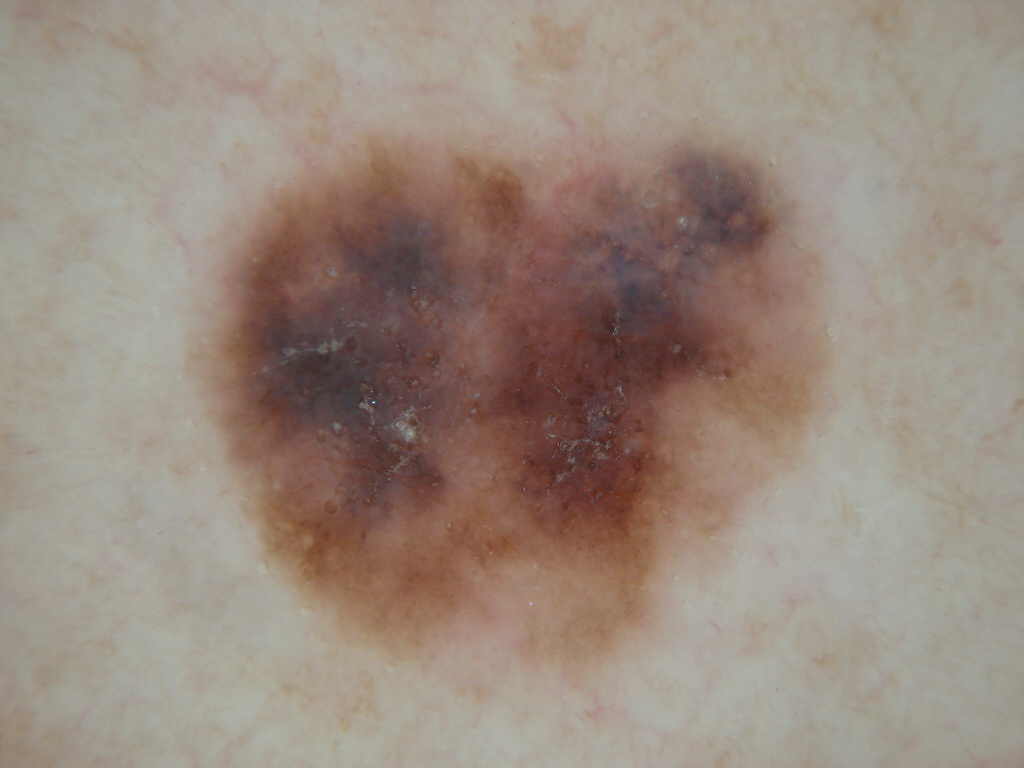

In [6]:
# Check if PIL works
from PIL import Image
Image.open(open("./data/train/melanoma/ISIC_0010034.jpg", 'rb'))

In [8]:
! pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x586f6000 @  0x7f4e00c931c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 21.2MB/s 
    100% |████████████████████████████████| 2.0MB 5.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Imports 

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import datasets, transforms, models
from collections import OrderedDict

## Explore data 

In [18]:
import glob 
import cv2

paths = ["data/train/melanoma", 
         "data/train/nevus",
         "data/train/seborrheic_keratosis"]

img_paths = []

# Get a sample of 15 training images (5 for each class)
for i in range(3):
  cont = 0
  for file in glob.glob(paths[i]+"/*.jpg"):
    img_paths.append(file)
    if cont == 4:
      break
    cont +=1 
      
print(len(img_paths))
print(img_paths)

15
['data/train/melanoma/ISIC_0010034.jpg', 'data/train/melanoma/ISIC_0014795.jpg', 'data/train/melanoma/ISIC_0010194.jpg', 'data/train/melanoma/ISIC_0015166.jpg', 'data/train/melanoma/ISIC_0014163.jpg', 'data/train/nevus/ISIC_0009938.jpg', 'data/train/nevus/ISIC_0011300.jpg', 'data/train/nevus/ISIC_0013120.jpg', 'data/train/nevus/ISIC_0000546.jpg', 'data/train/nevus/ISIC_0009914.jpg', 'data/train/seborrheic_keratosis/ISIC_0013731.jpg', 'data/train/seborrheic_keratosis/ISIC_0012719.jpg', 'data/train/seborrheic_keratosis/ISIC_0012103.jpg', 'data/train/seborrheic_keratosis/ISIC_0014628.jpg', 'data/train/seborrheic_keratosis/ISIC_0014650.jpg']


In [19]:
# Read images 
images = []
for path in img_paths: 
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

# Check if images has the same shape
for i in range(len(images)):
  print("image: ", i, " has shape: ", images[i].shape)

image:  0  has shape:  (768, 1024, 3)
image:  1  has shape:  (4420, 6641, 3)
image:  2  has shape:  (768, 1024, 3)
image:  3  has shape:  (4459, 6627, 3)
image:  4  has shape:  (2848, 4288, 3)
image:  5  has shape:  (768, 1024, 3)
image:  6  has shape:  (768, 1024, 3)
image:  7  has shape:  (2592, 3872, 3)
image:  8  has shape:  (719, 824, 3)
image:  9  has shape:  (768, 1024, 3)
image:  10  has shape:  (2592, 3872, 3)
image:  11  has shape:  (2000, 3008, 3)
image:  12  has shape:  (2000, 3008, 3)
image:  13  has shape:  (1936, 2592, 3)
image:  14  has shape:  (1936, 2592, 3)


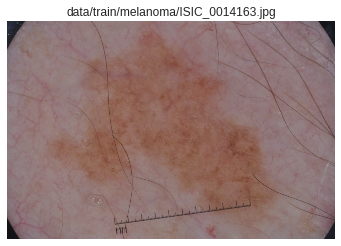

In [32]:
# Visualize image
index = 4

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title(img_paths[index])
ax1.imshow(images[index])

## Check model architecture for transfer learning

In [10]:
model = models.inception_v3(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:02<00:00, 50434287.54it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## Load data

In [0]:
root_path = "data/"

# With data augmentation
train_transforms = transforms.Compose([transforms.Resize(300),
                                       transforms.CenterCrop(299),
                                       transforms.RandomRotation(0, 359),
                                       transforms.RandomVerticalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(300),
                                       transforms.CenterCrop(299),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(root_path+'train', transform=train_transforms)
valid_data = datasets.ImageFolder(root_path+'valid', transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

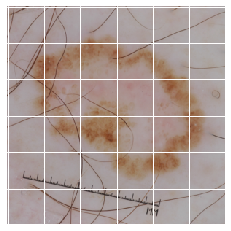

In [19]:
import numpy as np 

def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
  
  if normalize:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')
  return ax

images, labels = next(iter(trainloader))
imshow(images[7])

## Build model

### Freeze parameters of inception-v3

In [0]:
for parameters in model.parameters():
  parameters.requires_grad = False 

### Create the classifier

In [0]:
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                         ('relu', nn.ReLU()),
                                         ('fc2', nn.Linear(512, 3)),
                                         ('output', nn.Softmax(dim=1))]))

classifier2 = nn.Sequential(OrderedDict([('pool1', nn.Dropout2d(0.2)),
                                         ('fc1', nn.Linear(2048, 1024)),
                                         ('relu', nn.ReLU()),
                                         ('pool2', nn.Dropout(0.2)),
                                         ('fc2', nn.Linear(1024, 3)),
                                         ('output', nn.Softmax(dim=1))]))

model.fc = classifier2

## Train classifier

### Check for GPU

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Accuracy before training

In [26]:
def accuracy(testloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, aux = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network %d %%' % (100 * correct / total))
    
accuracy(validloader)

Accuracy of the network 24 %


### Check how much time will take on a simple batch

In [19]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001, eps=0.1, weight_decay=0.9, momentum=0.9)

model.to(device)
model.train()

inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

start = time.time()

outputs = model.forward(inputs)

# Inception has multiple outputs
loss = sum((criterion(out, labels) for out in outputs))
loss.backward()
optimizer.step()

print(f"Device = GPU; Time per batch: {(time.time() - start):.3f} seconds")

Device = GPU; Time per batch: 0.048 seconds


### Train classifier

In [25]:
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model.forward(images)
      test_loss += criterion(outputs, labels).item()
      ps = torch.exp(outputs)
      equality = (labels.data == ps.max(dim=1)[1])
      accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy
  
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001, eps=0.1, weight_decay=0.9, momentum=0.9)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.to(device)
running_loss = 0
step = 0
print_every = 1
model.train()
start = time.time()
for inputs, labels in trainloader:
  inputs, labels = inputs.to(device), labels.to(device)
  step += 1
  optimizer.zero_grad()
  outputs = model.forward(inputs)
  loss = sum((criterion(out, labels) for out in outputs))
  loss.backward()
  optimizer.step()
  running_loss += loss.item()
  if step % print_every == 0:
    model.eval()
    with torch.no_grad():
      test_loss, accuracy = validation(model, validloader, criterion)
      print("Epoch: {}/{}.. ".format(1,1),
            "Training Loss: {:.3f}.. ".format(running_loss/print_every),
            "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))
    running_loss = 0
    model.train()
print(f"Time per epoch: {(time.time() - start):.3f} seconds")
    

Epoch: 1/1..  Training Loss: 9.480..  Test Loss: 1.063..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.154..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.212..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.230..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.157..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.082..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.115..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.071..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.002..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.180..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.147..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.269..  Test Loss: 1.064..  Test Accuracy: 0.488
Epoch: 1/1..  Training Loss: 9.348..  Test Loss: 1.0

### Check accuracy

In [79]:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, aux = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 600 test images: %d %%' % (100 * correct / total))
model.train()   
check_accuracy_on_test(validloader)

Accuracy of the network on the 600 test images: 52 %


In [ ]:
checkpoint = {'input_size': 224*224,
              'output_size': 3,
              'hidden_alyers': [each.out_features for each in model.hidden_layers],
              'state_dict': mode.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')